🚀 Start Analysis: BTC
✅ Loaded 729 rows
🔍 Head & Shoulders found: 3


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


📈 LSTM MAE: 0.01


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📊 CNN Classification Report
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85       103
         1.0       0.00      0.00      0.00        37

    accuracy                           0.74       140
   macro avg       0.37      0.50      0.42       140
weighted avg       0.54      0.74      0.62       140

📰 Running Sentiment Analysis...


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

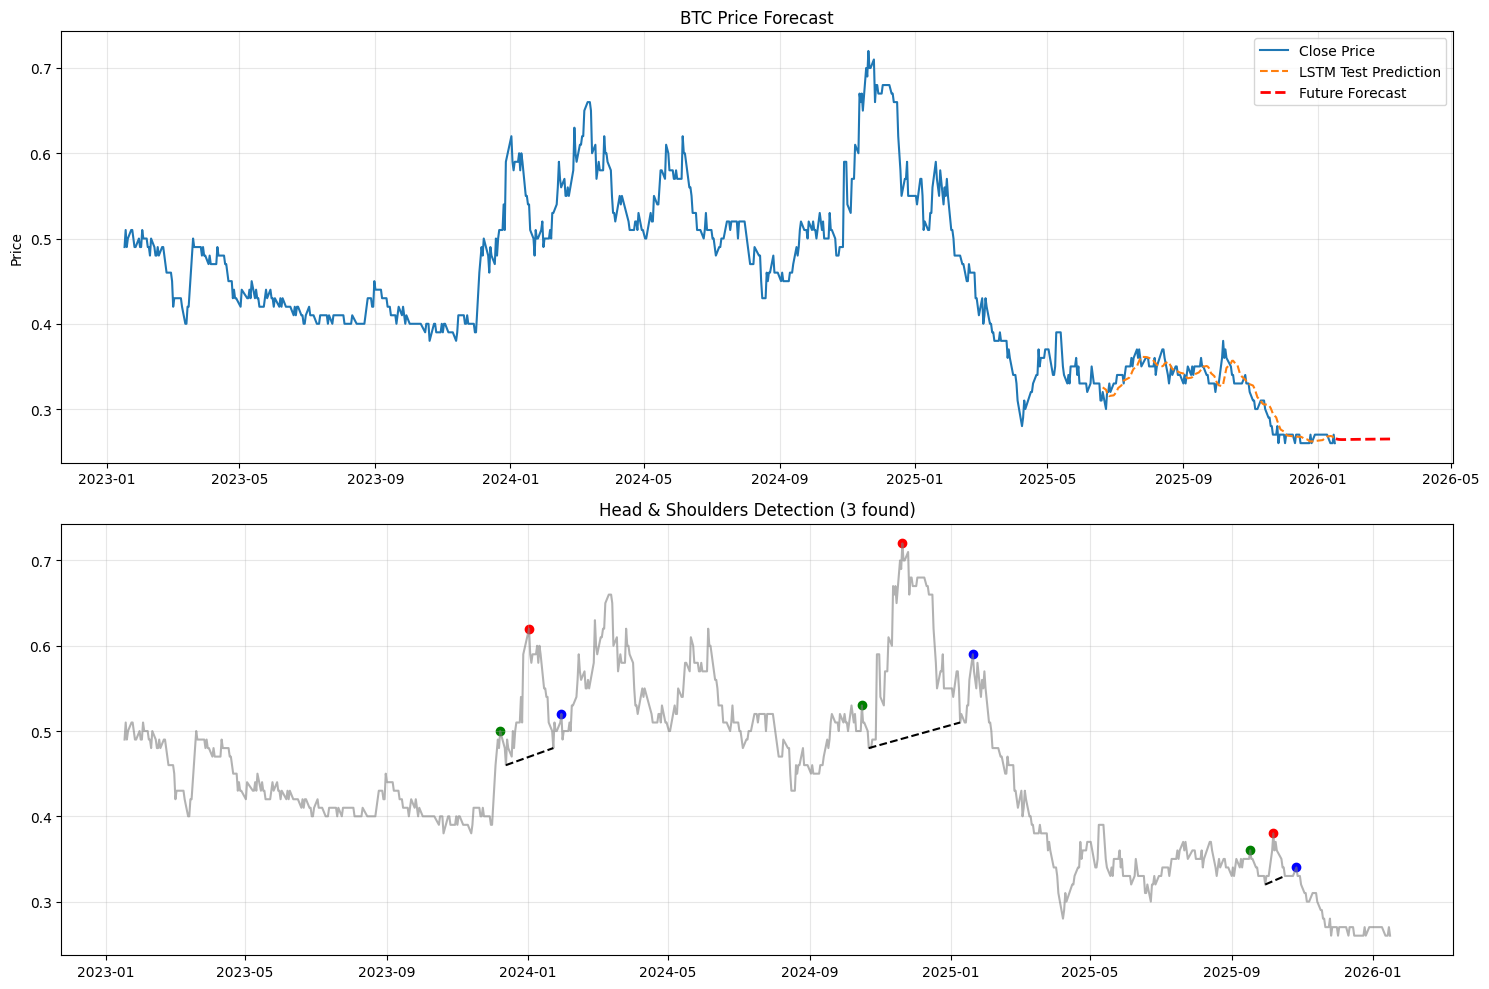


📊 SUMMARY: BTC
Tomorrow Forecast: 0.27
Sentiment Score: -0.39 (Negative 🔴)
Technical Signal: ⚠️ H&S Detected


In [4]:
# ========================================
# Multi-Modal Market Intelligence System
# LSTM (Forecast) + CNN (Pattern) + NLP (Sentiment)
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from cassandra.cluster import Cluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.utils import class_weight

from transformers import pipeline

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# ========================================
# 1. CONFIG
# ========================================
SYMBOL = "BTC"
CASSANDRA_HOST = "127.0.0.1"
CASSANDRA_PORT = 9042

SEQ_LEN = 30
FORECAST_DAYS = 50
TRAIN_SPLIT = 0.8

# ========================================
# 2. DATA LOADING
# ========================================
def get_data(symbol):
    cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
    session = cluster.connect("data_stock")

    query = """
        SELECT time, open, high, low, close, volume
        FROM candlestick_data
        WHERE symbol=%s
        LIMIT 1000 ALLOW FILTERING
    """

    df = pd.DataFrame(list(session.execute(query, (symbol,))))
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").reset_index(drop=True)

    cluster.shutdown()
    return df


print(f"🚀 Start Analysis: {SYMBOL}")
df = get_data(SYMBOL)
print(f"✅ Loaded {len(df)} rows")

# ========================================
# 3. HEAD & SHOULDERS LABELING (Heuristic)
# ========================================
def get_hs_labels(df, window=5):
    prices = df["close"].values
    labels = np.zeros(len(prices))

    peaks = [
        i for i in range(window, len(prices) - window)
        if all(prices[i] > prices[i - j] and prices[i] > prices[i + j] for j in range(1, window + 1))
    ]

    patterns = []

    for i in range(len(peaks) - 2):
        ls, h, rs = peaks[i], peaks[i + 1], peaks[i + 2]

        if (
            prices[h] > prices[ls] * 1.03 and
            prices[h] > prices[rs] * 1.03 and
            abs(prices[ls] - prices[rs]) / prices[ls] < 0.12
        ):
            labels[ls - 5 : rs + 6] = 1

            lv = ls + np.argmin(prices[ls:h + 1])
            rv = h + np.argmin(prices[h:rs + 1])

            patterns.append({
                "ls": (ls, prices[ls]),
                "h": (h, prices[h]),
                "rs": (rs, prices[rs]),
                "neck": [(lv, prices[lv]), (rv, prices[rv])]
            })

    return labels, patterns


labels, patterns_found = get_hs_labels(df)
print(f"🔍 Head & Shoulders found: {len(patterns_found)}")

# ========================================
# 4. LSTM PRICE FORECASTING (UNIVARIATE)
# ========================================
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df[["close"]])

X_l, y_l = [], []
for i in range(len(close_scaled) - SEQ_LEN):
    X_l.append(close_scaled[i:i + SEQ_LEN])
    y_l.append(close_scaled[i + SEQ_LEN])

X_l, y_l = np.array(X_l), np.array(y_l)

split = int(len(X_l) * TRAIN_SPLIT)

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")

model_lstm.fit(
    X_l[:split], y_l[:split],
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# --- Test Prediction
y_test_pred = model_lstm.predict(X_l[split:], verbose=0)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_test_true_inv = scaler.inverse_transform(y_l[split:])

mae = mean_absolute_error(y_test_true_inv, y_test_pred_inv)
print(f"📈 LSTM MAE: {mae:.2f}")

test_times = df["time"].iloc[split + SEQ_LEN : split + SEQ_LEN + len(y_test_pred)]

# --- Future Forecast
curr_seq = close_scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
future_preds = []

for _ in range(FORECAST_DAYS):
    next_p = model_lstm.predict(curr_seq, verbose=0)[0, 0]
    future_preds.append(next_p)
    curr_seq = np.append(curr_seq[:, 1:, :], [[[next_p]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# ========================================
# 5. CNN – HEAD & SHOULDERS CLASSIFICATION
# ========================================
scaler_cnn = MinMaxScaler()
cnn_features = scaler_cnn.fit_transform(df[["close", "volume"]])

X_c, y_c = [], []
for i in range(len(cnn_features) - SEQ_LEN):
    X_c.append(cnn_features[i:i + SEQ_LEN])
    y_c.append(labels[i + SEQ_LEN])

X_c, y_c = np.array(X_c), np.array(y_c)

classes = np.unique(y_c[:split])

if len(classes) > 1:
    cw_values = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y_c[:split]
    )
    cw = dict(zip(classes, cw_values))
else:
    cw = {0: 1.0, 1: 1.0}


model_cnn = Sequential([
    Conv1D(32, 3, activation="relu", input_shape=(SEQ_LEN, 2)),
    MaxPooling1D(2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_cnn.fit(
    X_c[:split], y_c[:split],
    epochs=20,
    batch_size=32,
    verbose=0,
    class_weight=cw
)

y_cnn_pred = (model_cnn.predict(X_c[split:], verbose=0) > 0.5).astype(int)
print("\n📊 CNN Classification Report")
print(classification_report(y_c[split:], y_cnn_pred))

# ========================================
# 6. NLP SENTIMENT ANALYSIS
# ========================================
print("📰 Running Sentiment Analysis...")
try:
    sentiment = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english"
    )

    news = [
        f"{SYMBOL} shows strong institutional adoption",
        f"Concerns rise over regulation impact on {SYMBOL}",
        f"Large investors accumulate {SYMBOL}",
        f"Market volatility pressures {SYMBOL} price"
    ]

    results = sentiment(news)
    scores = [r["score"] if r["label"] == "POSITIVE" else -r["score"] for r in results]
    avg_sentiment = np.mean(scores)

except Exception as e:
    print("⚠️ Sentiment Error:", e)
    avg_sentiment = 0

sentiment_label = "Positive 🟢" if avg_sentiment > 0 else "Negative 🔴"

# ========================================
# 7. VISUALIZATION
# ========================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# --- Price & Forecast
ax1.plot(df["time"], df["close"], label="Close Price", lw=1.5)
ax1.plot(test_times, y_test_pred_inv, "--", label="LSTM Test Prediction")

future_dates = pd.date_range(df["time"].iloc[-1] + timedelta(days=1), periods=FORECAST_DAYS)
ax1.plot(future_dates, future_prices, "r--", lw=2, label="Future Forecast")

ax1.set_title(f"{SYMBOL} Price Forecast")
ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(alpha=0.3)

# --- Pattern Detection
ax2.plot(df["time"], df["close"], color="gray", alpha=0.6)
for p in patterns_found:
    ax2.scatter(df["time"].iloc[p["ls"][0]], p["ls"][1], color="green")
    ax2.scatter(df["time"].iloc[p["h"][0]], p["h"][1], color="red")
    ax2.scatter(df["time"].iloc[p["rs"][0]], p["rs"][1], color="blue")
    ax2.plot(
        [df["time"].iloc[p["neck"][0][0]], df["time"].iloc[p["neck"][1][0]]],
        [p["neck"][0][1], p["neck"][1][1]],
        "k--"
    )

ax2.set_title(f"Head & Shoulders Detection ({len(patterns_found)} found)")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 8. SUMMARY
# ========================================
print("\n" + "=" * 50)
print(f"📊 SUMMARY: {SYMBOL}")
print(f"Tomorrow Forecast: {future_prices[0][0]:.2f}")
print(f"Sentiment Score: {avg_sentiment:.2f} ({sentiment_label})")
print(f"Technical Signal: {'⚠️ H&S Detected' if len(patterns_found) else 'No Warning'}")
print("=" * 50)
